In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

sns.set_style('darkgrid')
from scipy.stats import skew, norm, probplot

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import Ridge, HuberRegressor, LinearRegression
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

from utils import one_hot_encode_categorical_cols
from utils import has_null, null_count, plot_simple, plot_values_distribution
from utils import get_mean, get_mode, get_col_names, get_col_dtype

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [77]:
df = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [78]:
y = df['SalePrice']
df = df.set_index('Id')
test = test.set_index('Id')
y.shape, df.shape, test.shape

((1460,), (1460, 80), (1459, 79))

-------------------------
Total columns with null:
34
-------------------------
Total null values:
13965
-------------------------


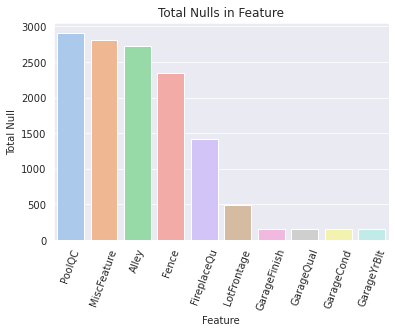

In [79]:
null_list = []
for col in df.columns:
    if col == 'SalePrice':
        continue
    null = df[col].isnull().sum()
    test_null = test[col].isnull().sum()
    if null != 0 or test_null != 0:
        null_list.append([col, null, test_null])
        
null_df = pd.DataFrame(null_list, columns=['Feature', 'Null', 'Test Null'])
null_df.set_index('Feature')
null_df['Total Null'] = null_df['Null'] + null_df['Test Null']

print("-------------------------")
print("Total columns with null:")
print(len(null_df))
print("-------------------------")
print("Total null values:")
print(null_df['Total Null'].sum(axis=0))
print("-------------------------")

sns.set_palette(sns.color_palette("pastel"))
sns.barplot(data=null_df.sort_values(by='Total Null', ascending = False).head(10), x='Feature', y='Total Null')
plt.xticks(rotation = 70)
plt.title("Total Nulls in Feature")
plt.show()

In [6]:
full = pd.concat([df, test],axis=0).reset_index(drop=True)

In [7]:
null_count([df, test], list(test.columns))

/home/jovyan/workspace/utils.py:132: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  null_df['Total Null'] = null_df.sum(axis=1)


,feature,df_0_null,df_0_mode,df_0_mean,df_0_nuniq,df_1_null,df_1_mode,df_1_mean,df_1_nuniq,dtype,Total Null,df_0_null_pct,df_1_null_pct
30,PoolQC,1453,Gd,,3,1456,Ex,,2,object,2909,0.995205,0.997944
32,MiscFeature,1406,Shed,,4,1408,Shed,,3,object,2814,0.963014,0.965045
2,Alley,1369,Grvl,,2,1352,Grvl,,2,object,2721,0.937671,0.926662
31,Fence,1179,MnPrv,,4,1169,MnPrv,,4,object,2348,0.807534,0.801234
22,FireplaceQu,690,Gd,,5,730,Gd,,5,object,1420,0.472603,0.500343
1,LotFrontage,259,60.0,70.049958,,227,60.0,68.580357,,float64,486,0.177397,0.155586
25,GarageFinish,81,Unf,,3,78,Unf,,3,object,159,0.055479,0.053461
28,GarageQual,81,TA,,5,78,TA,,4,object,159,0.055479,0.053461
29,GarageCond,81,TA,,5,78,TA,,5,object,159,0.055479,0.053461
24,GarageYrBlt,81,2005.0,1978.506164,,78,2005.0,1977.721217,,float64,159,0.055479,0.053461


In [8]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
categorical_cols = df.select_dtypes(include=["object"]).columns
print(categorical_cols)
print(len(categorical_cols))

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
43


In [10]:
numerical_cols = df.select_dtypes(include=['number']).columns
print(numerical_cols)
print(len(numerical_cols))

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
37


,Neighborhood,MSZoning
Id,,
1916,IDOTRR,NaN
2217,IDOTRR,NaN
2251,IDOTRR,NaN
2905,Mitchel,NaN


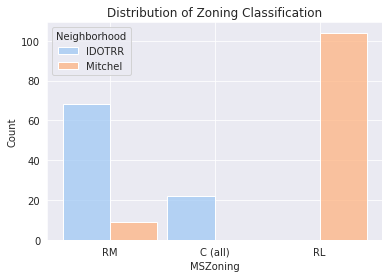

In [11]:
null = test[test['MSZoning'].isnull()][["Neighborhood","MSZoning"]]
display(null)
plot_data = pd.concat([full[full['Neighborhood'] == 'IDOTRR'], full[full['Neighborhood'] == 'Mitchel']], axis = 0)
sns.histplot(data=plot_data, x='MSZoning', hue='Neighborhood', multiple="dodge", shrink=.9)
plt.title("Distribution of Zoning Classification")
plt.show()

In [13]:
test.loc[(test['Neighborhood'] == 'IDOTRR') & (test['MSZoning'].isnull()), 'MSZoning'] = 'RM'
test.loc[(test['Neighborhood'] == 'Mitchel') & (test['MSZoning'].isnull()), 'MSZoning'] = 'RL'

## Modeling LotArea and LotFrontage relationship

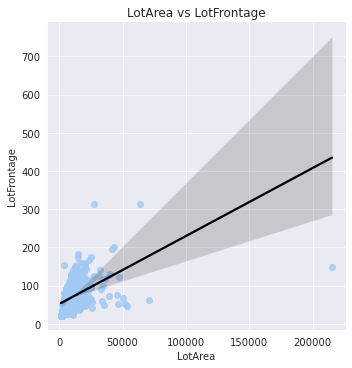

In [14]:
data = full[~full['LotFrontage'].isnull()]
sns.lmplot(data=data, x="LotArea", y="LotFrontage", line_kws={'color': 'black'})
plt.ylabel("LotFrontage")
plt.xlabel("LotArea")
plt.title("LotArea vs LotFrontage")
plt.show()

<AxesSubplot:ylabel='Frequency'>

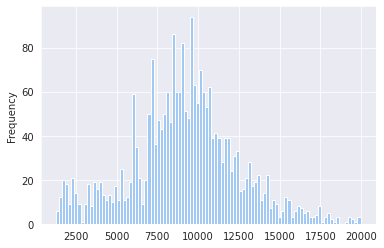

In [15]:
full.query("LotFrontage <= 150 & LotArea <= 20000")['LotArea'].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

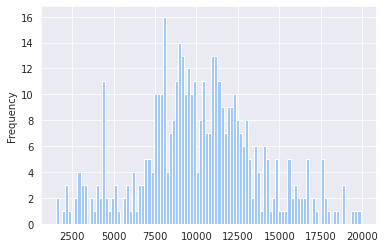

In [17]:
# distribution of LotArea where LotFrontage is null
full.query("LotFrontage != LotFrontage & LotArea <= 20000")['LotArea'].plot.hist(bins=100)

In [18]:
print(len(full[~full['LotFrontage'].isnull()]), 'not null values')
print(len(full[full['LotFrontage'] <= 150]))
print(len(full[full['LotArea'] <= 20000]))

2433 not null values
2419
2829


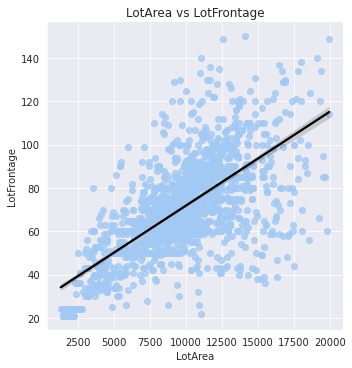

In [19]:
data = full[(~full['LotFrontage'].isnull()) & (full['LotFrontage'] <= 150) & (full['LotArea'] <= 20000)]
sns.lmplot(data=data, x="LotArea", y="LotFrontage", line_kws={'color': 'black'})
plt.ylabel("LotFrontage")
plt.xlabel("LotArea")
plt.title("LotArea vs LotFrontage")
plt.show()

In [20]:
area_vs_frontage = LinearRegression()
area_vs_frontage_X = data['LotArea'].values.reshape(-1, 1)
area_vs_frontage_y = data['LotFrontage'].values
area_vs_frontage.fit(area_vs_frontage_X, area_vs_frontage_y)
for table in [df,test]:
    table['LotFrontage'].fillna(area_vs_frontage.intercept_ + table['LotArea'] * area_vs_frontage.coef_[0], inplace=True)

In [21]:
for table in [df,test]:
    table['Alley'].fillna("None",inplace=True)

In [22]:
full['Utilities'].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [23]:
null_count([df, test], list(test.columns)).query('feature == "Utilities"')

/home/jovyan/workspace/utils.py:132: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  null_df['Total Null'] = null_df.sum(axis=1)


,feature,df_0_null,df_0_mode,df_0_mean,df_0_nuniq,df_1_null,df_1_mode,df_1_mean,df_1_nuniq,dtype,Total Null,df_0_null_pct,df_1_null_pct
1,Utilities,0,AllPub,,2,2,AllPub,,1,object,2,0.0,0.001371


In [24]:
test['Utilities'].fillna("AllPub", inplace=True)

In [23]:
#df.drop(df[df['Utilities'] == 'NoSeWa'].index, inplace=True)

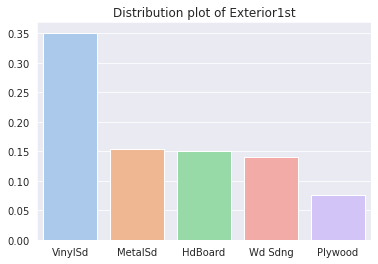

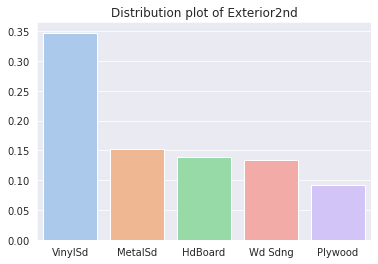

In [25]:
for metrics in ['Exterior1st','Exterior2nd']:
    table = full[metrics].value_counts(normalize=True).head()
    sns.barplot(x=table.index,y=table.values)
    plt.title("Distribution plot of "+metrics)
    plt.show()

In [26]:
test['Exterior1st'] = test['Exterior1st'].fillna(full['Exterior1st'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(full['Exterior2nd'].mode()[0])

In [27]:
test[test['MasVnrType'].isnull() & test['MasVnrArea'].notnull()][['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
Id,,
2611,NaN,198.0


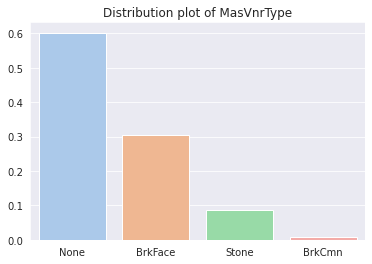

In [28]:
table = full['MasVnrType'].value_counts(normalize=True).head()
sns.barplot(x=table.index,y=table.values)
plt.title("Distribution plot of MasVnrType")
plt.show()

In [29]:
test['MasVnrType'][2611] = "BrkFace"
test['MasVnrType'] = test['MasVnrType'].fillna(full['MasVnrType'].mode()[0])
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)
df['MasVnrType'] = df['MasVnrType'].fillna(full['MasVnrType'].mode()[0])
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

/tmp/ipykernel_76/1477495461.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['MasVnrType'][2611] = "BrkFace"


In [30]:
for col in ['BsmtExposure','BsmtCond','BsmtQual', 'BsmtFinType1']:
    print(full[col].value_counts())

No    1904
Av     418
Gd     276
Mn     239
Name: BsmtExposure, dtype: int64
TA    2606
Gd     122
Fa     104
Po       5
Name: BsmtCond, dtype: int64
TA    1283
Gd    1209
Ex     258
Fa      88
Name: BsmtQual, dtype: int64
Unf    851
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: BsmtFinType1, dtype: int64


In [31]:
for col in ['BsmtExposure','BsmtCond','BsmtQual']:
    query = full[col].notnull() & full['BsmtFinType1'].isnull()
    if len(full[query]) > 0 :
        print("\nRows with "+ col +" but BsmtFinType1 missing" )
        display(full[query])

In [32]:
for col in ['BsmtExposure','BsmtCond','BsmtQual']:
    query = full[col].isnull() & full['BsmtFinType1'].notnull()
    if len(full[query]) > 0 :
        print("\nRows with missing "+ col +" but BsmtFinType1 has value" )
        display(full[query][[col, 'BsmtFinType1']])


Rows with missing BsmtExposure but BsmtFinType1 has value


,BsmtExposure,BsmtFinType1
948,NaN,Unf
1487,NaN,Unf
2348,NaN,Unf



Rows with missing BsmtCond but BsmtFinType1 has value


,BsmtCond,BsmtFinType1
2040,NaN,GLQ
2185,NaN,BLQ
2524,NaN,ALQ



Rows with missing BsmtQual but BsmtFinType1 has value


,BsmtQual,BsmtFinType1
2217,NaN,Unf
2218,NaN,Unf


In [33]:
# We assume missing basement exposure of unfinished basement is "No".
df.loc[((df['BsmtExposure'].isnull()) & (df['BsmtFinType1'].notnull())), 'BsmtExposure'] = 'No'
test.loc[((test['BsmtExposure'].isnull()) & (test['BsmtFinType1'].notnull())), 'BsmtExposure'] = 'No'

# We impute missing basement condition with "mean" value of Typical.
test.loc[((test['BsmtCond'].isnull()) & (test['BsmtFinType1'].notnull())), 'BsmtCond'] = 'TA'

# We impute unfinished basement quality with "mean" value of Typical.
test.loc[((test['BsmtQual'].isnull()) & (test['BsmtFinType1'].notnull())), 'BsmtQual'] = 'TA'

In [34]:
test[test['BsmtFinSF1'].isnull()].filter(like='Bsmt')

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
2121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
for col in ['TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']:
    test[col][2121] = 0

/tmp/ipykernel_76/682951547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col][2121] = 0


In [36]:
test[test['BsmtFullBath'].isnull()].filter(like='Bath')

,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath
Id,,,,
2121,NaN,NaN,1,0
2189,NaN,NaN,3,1


In [37]:
for col in ['BsmtFullBath','BsmtHalfBath']:
    test[col][2121] = 0
    test[col][2189] = 0

/tmp/ipykernel_76/3801676781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col][2121] = 0
/tmp/ipykernel_76/3801676781.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col][2189] = 0


In [38]:
cols = get_col_names(df, 'Bsmt')
cols = list(get_col_dtype(df, cols)['feature'])
cols

['BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1']

In [39]:
for table in [df,test]:
    table[cols] = table[cols].fillna("None")

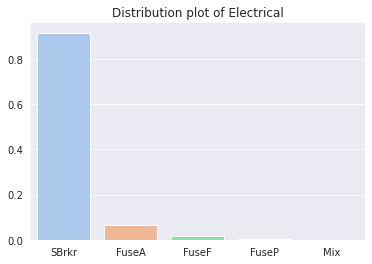

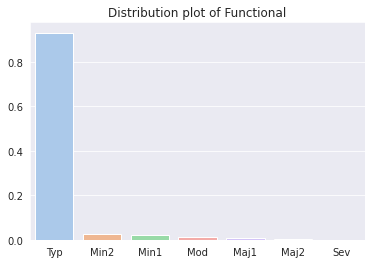

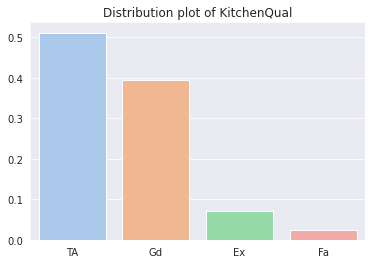

In [40]:
for col in ['Electrical','Functional','KitchenQual']:
    table = full[col].value_counts(normalize=True)
    sns.barplot(x=table.index,y=table.values)
    plt.title("Distribution plot of "+col)
    plt.show()

In [41]:
df['Electrical'].fillna('SBrkr',inplace=True)
test['Functional'].fillna('Typ',inplace=True)
test['KitchenQual'].fillna('TA',inplace=True)

In [45]:
has_null(test, 'Electrical')

False

## Garage related null values

In [46]:
full['GarageCars'].value_counts()

2.0    1594
1.0     776
3.0     374
0.0     157
4.0      16
5.0       1
Name: GarageCars, dtype: int64

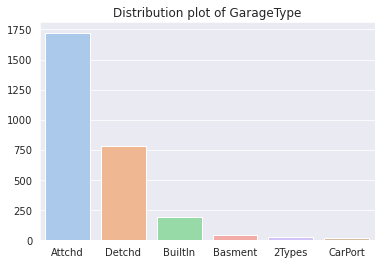

In [47]:
for col in ['GarageType']:
    plot_values_distribution(full, col)

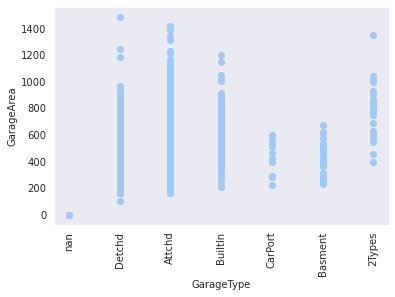

In [48]:
plot_simple(full, 'GarageType', 'GarageArea')

In [49]:
get_mode(full, "GarageType == 'Detchd'", 'GarageCars')

0    2.0
Name: GarageCars, dtype: float64

In [50]:
get_mean(full, "GarageType == 'Detchd'", 'GarageArea')

419.49228791773777

In [51]:
full[full['GarageCars'].isnull()][sorted(full.columns)]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
2576,942,886,0,NaN,3,1Fam,TA,No,548.0,0.0,ALQ,Unf,0.0,0.0,Gd,311.0,Y,Norm,Norm,SBrkr,212,TA,TA,Wd Sdng,Plywood,MnPrv,NaN,0,BrkTil,2,Typ,NaN,NaN,NaN,NaN,NaN,Detchd,NaN,1828,0,GasA,Ex,2Story,1,Gd,Lvl,Gtl,9060,Inside,50.0,Reg,0,70,RM,0.0,None,NaN,0,3,IDOTRR,0,6,5,Y,0,NaN,CompShg,Gable,Alloca,NaN,WD,0,Pave,6,859.0,AllPub,174,1923,1999,2007


In [52]:
test['GarageCars'].fillna(2, inplace=True)
test['GarageArea'].fillna(get_mean(full, "GarageType == 'Detchd'", 'GarageArea'), inplace=True)

In [53]:
test['SaleType'].fillna('WD',inplace=True)

In [54]:
cols = get_col_names(df, '')
cols = get_col_dtype(df, cols)

In [55]:
df['GarageYrBlt'].fillna(0,inplace=True)
test['GarageYrBlt'].fillna(0,inplace=True)


# fill all other null with None
df.fillna("None", inplace=True)
test.fillna("None", inplace=True)

In [56]:
null_count([df, test], list(test.columns))

,feature,df_0_null,df_0_mode,df_0_mean,df_0_nuniq,df_1_null,df_1_mode,df_1_mean,df_1_nuniq,dtype,Total Null,df_0_null_pct,df_1_null_pct


In [57]:
def calc_extra_features(data):
    data['Total_Square_Feet'] = data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['1stFlrSF'] + data['2ndFlrSF'] + data['TotalBsmtSF']
    data['Total_Bath'] = data['FullBath'] + (0.5 * data['HalfBath']) + data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath'])
    data['Total_Porch_Area'] = data['OpenPorchSF'] + data['3SsnPorch'] + data['EnclosedPorch'] + data['ScreenPorch'] + data['WoodDeckSF']
    data['SqFtPerRoom'] = data['GrLivArea'] / (data['TotRmsAbvGrd'] + data['FullBath'] + data['HalfBath'] + data['KitchenAbvGr'])
    
calc_extra_features(df)
calc_extra_features(test)

<AxesSubplot:>

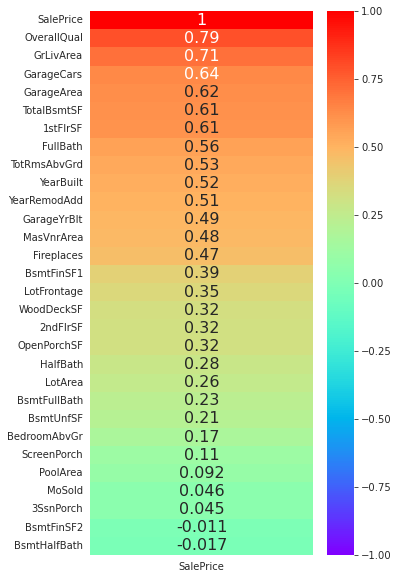

In [80]:
top_features = df.corr()[['SalePrice']].sort_values(by=['SalePrice'], ascending=False).head(30)
plt.figure(figsize=(5,10))
sns.heatmap(top_features,cmap='rainbow', annot=True, annot_kws={"size": 16}, vmin=-1)

In [58]:
df.shape, test.shape, y.shape

((1460, 84), (1459, 83), (1460,))

In [81]:
df['OverallQual'].dtype

dtype('int64')

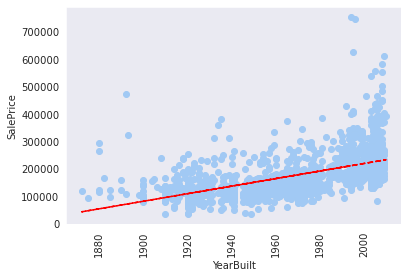

In [59]:
plot_simple(df, 'YearBuilt', 'SalePrice', show_fit=True)

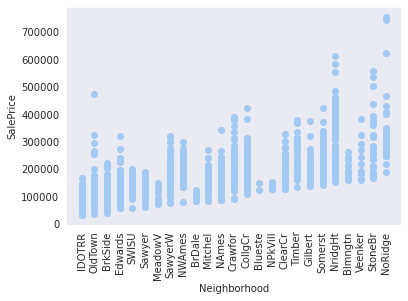

In [60]:
plot_simple(df, 'Neighborhood', 'SalePrice', show_fit=True)

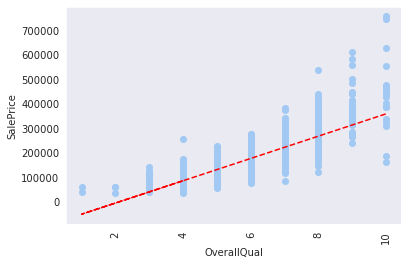

In [62]:
plot_simple(df, 'OverallQual', 'SalePrice', rotation='v', show_fit=True)

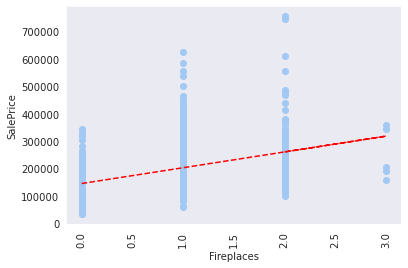

In [58]:
plot_simple(df, 'Fireplaces', 'SalePrice', show_fit=True)

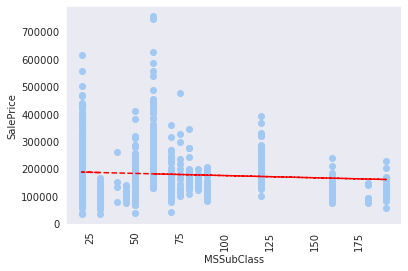

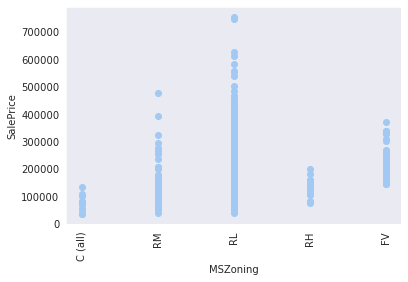

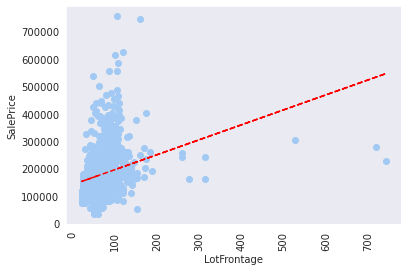

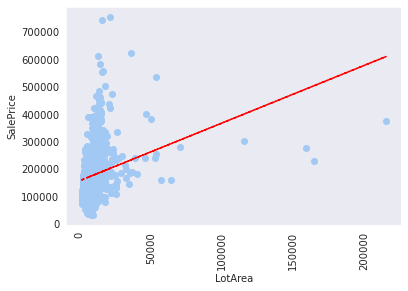

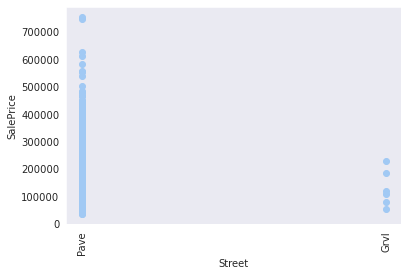

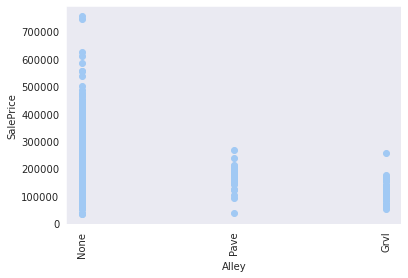

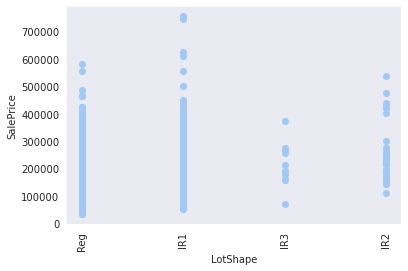

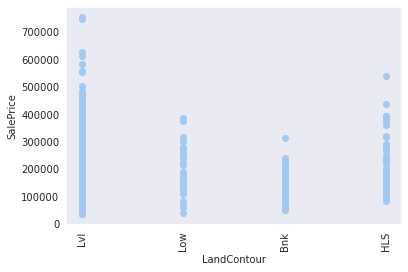

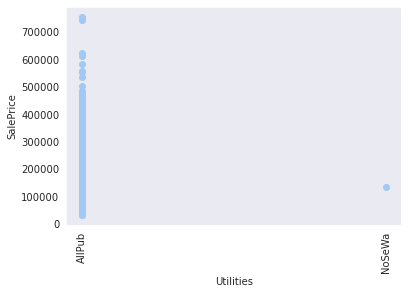

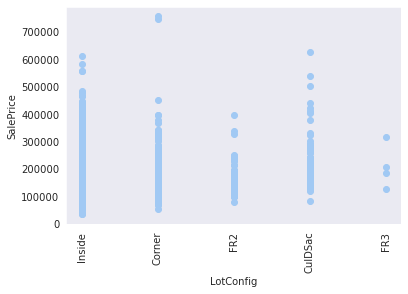

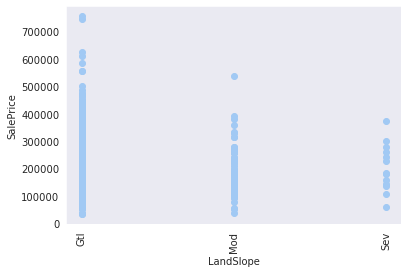

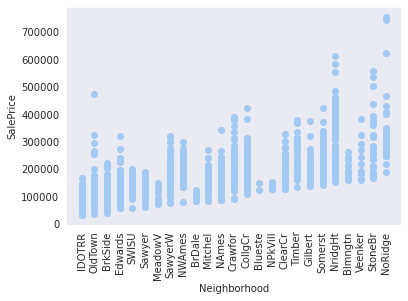

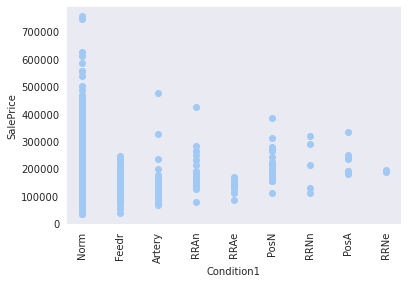

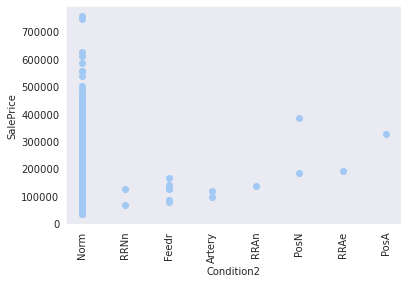

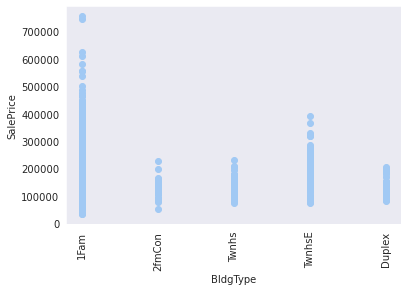

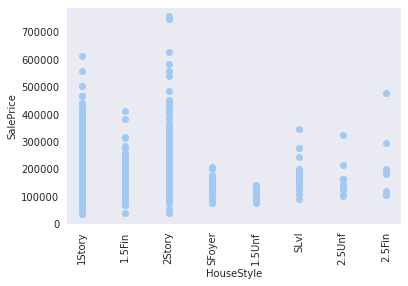

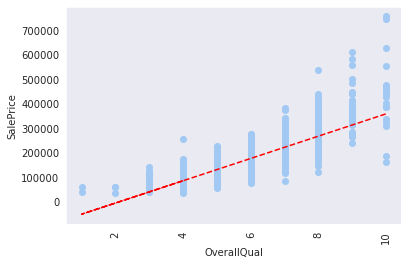

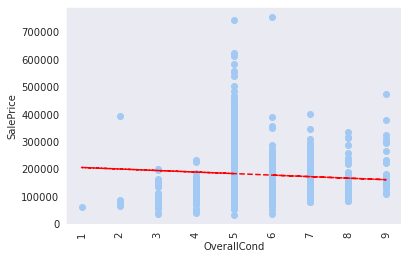

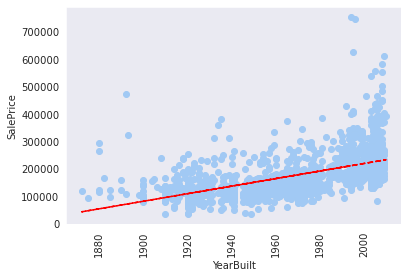

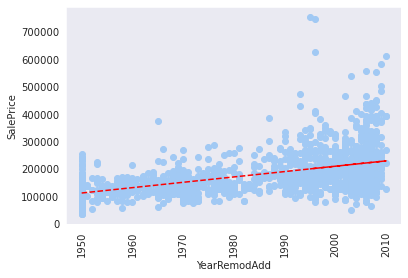

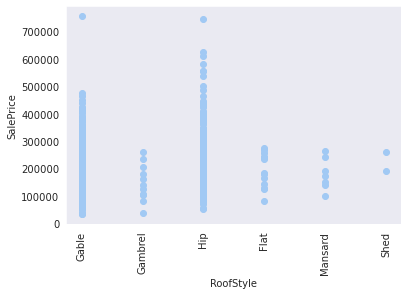

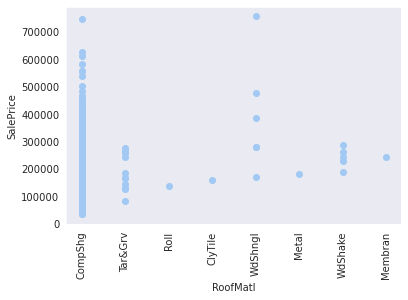

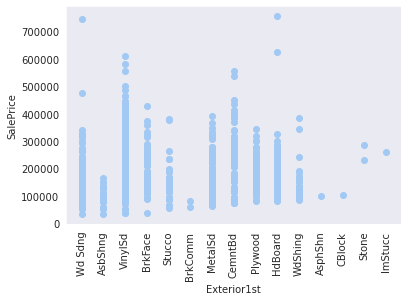

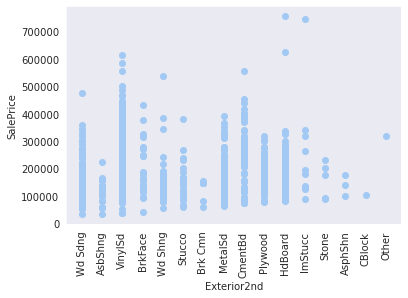

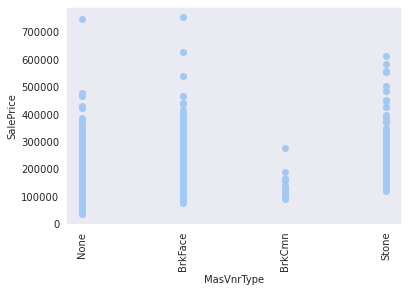

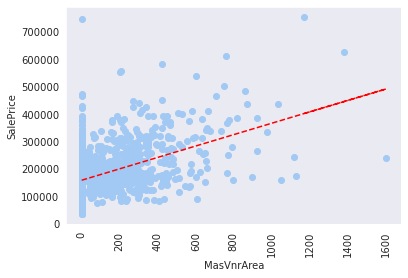

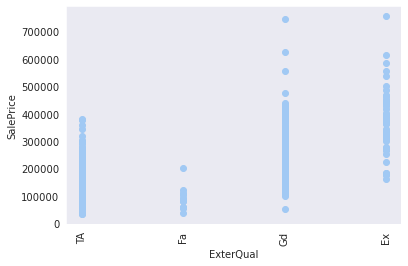

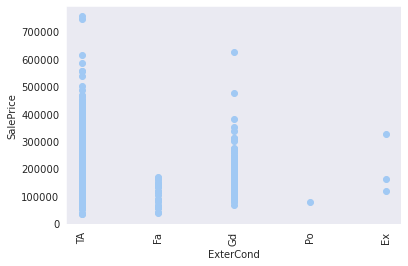

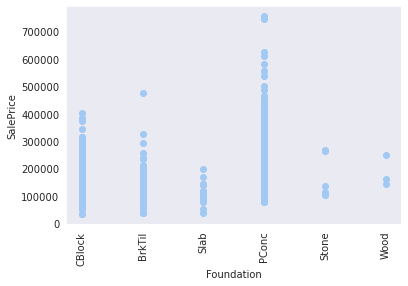

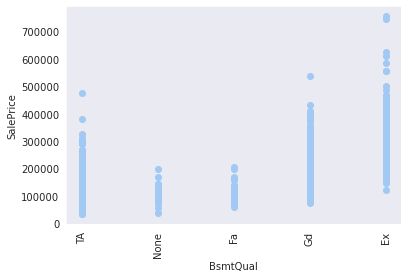

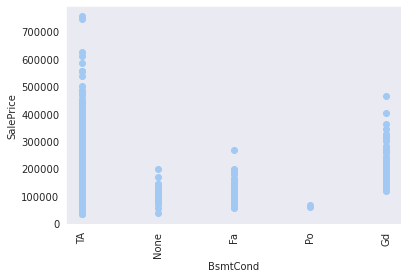

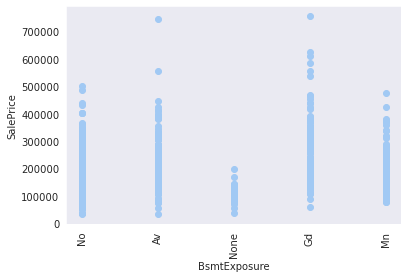

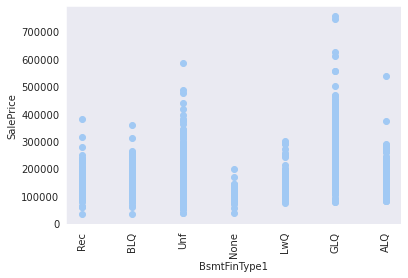

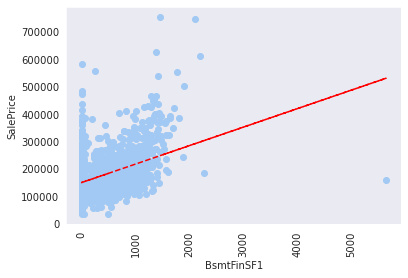

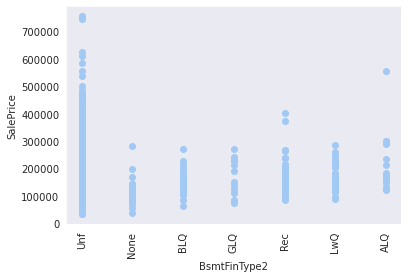

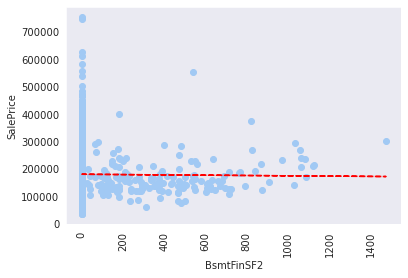

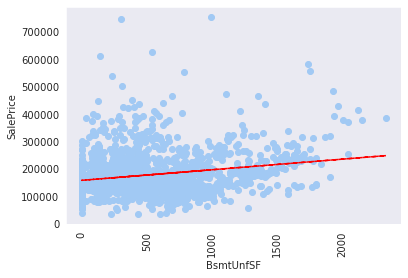

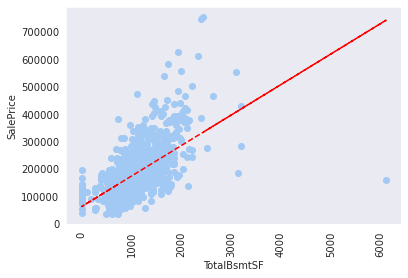

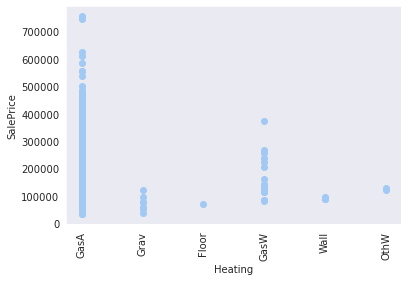

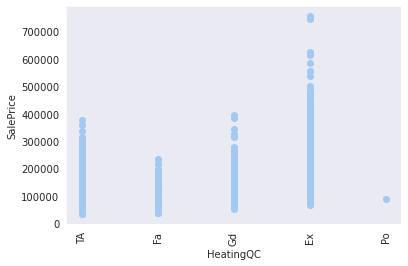

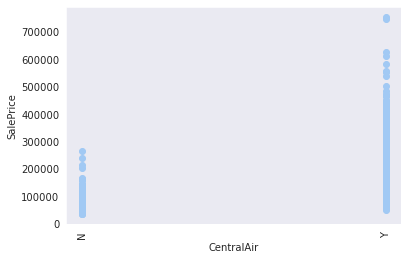

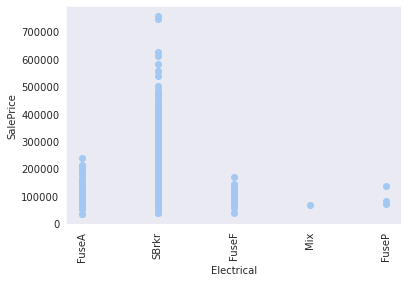

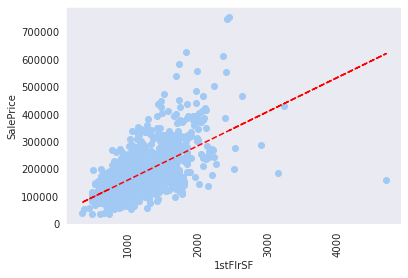

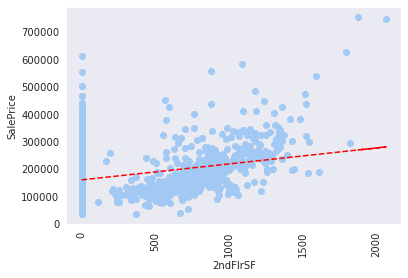

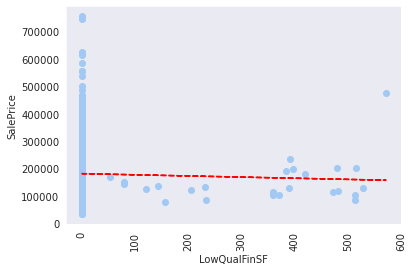

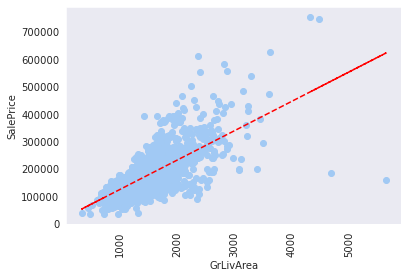

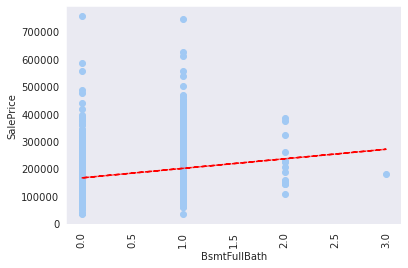

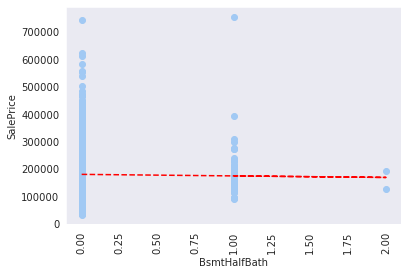

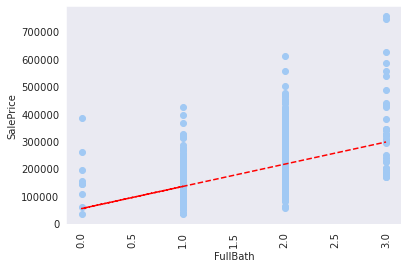

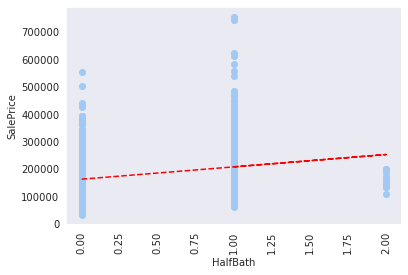

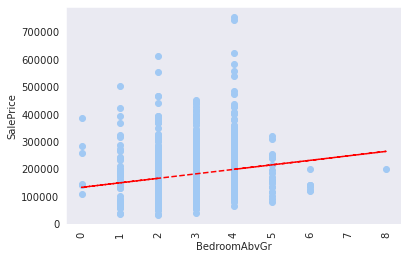

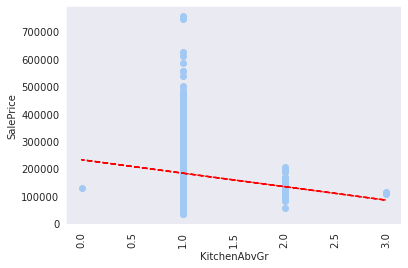

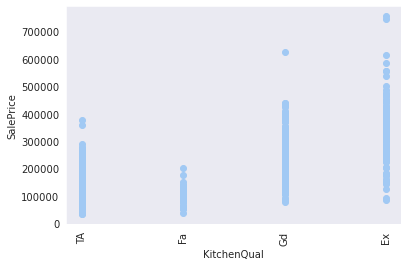

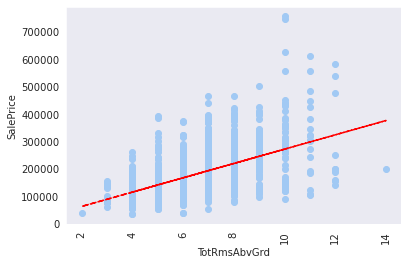

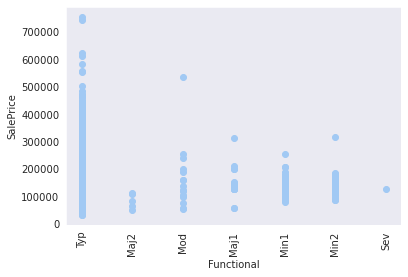

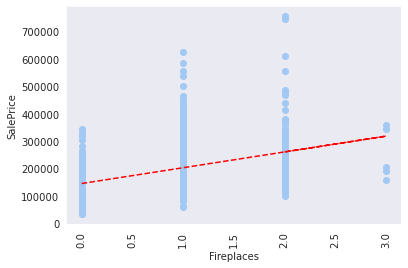

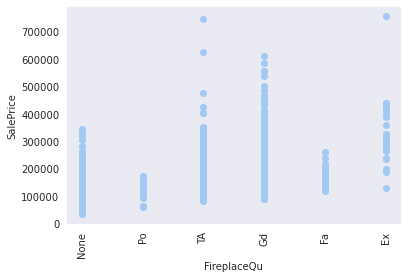

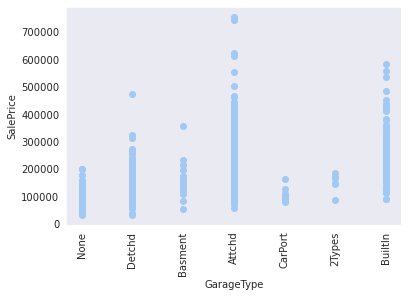

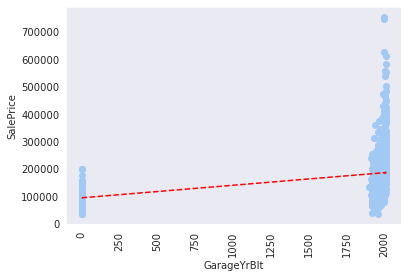

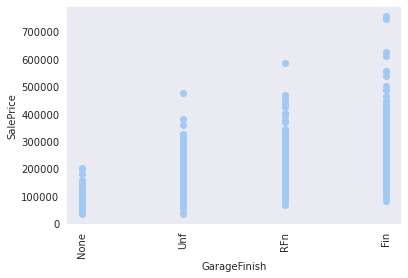

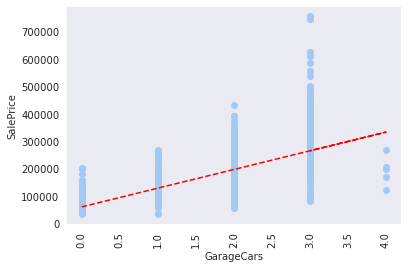

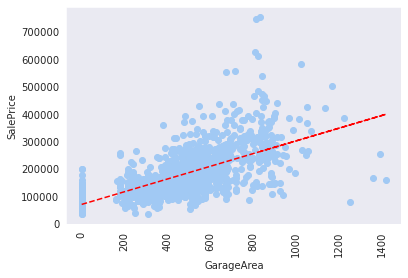

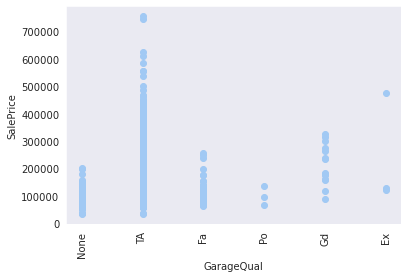

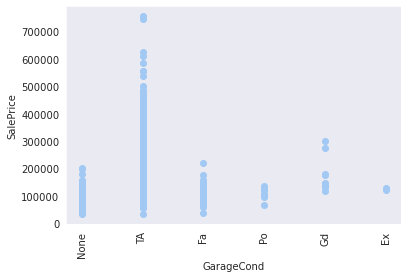

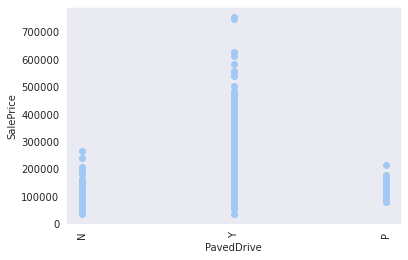

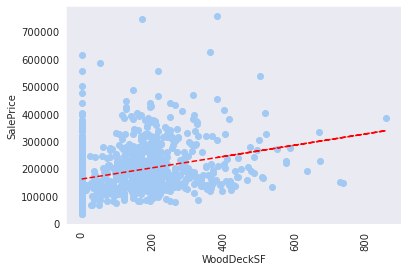

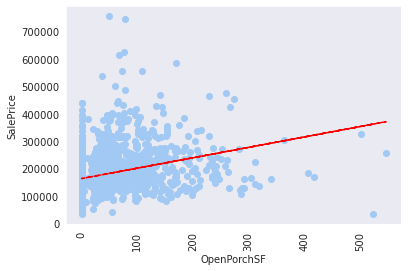

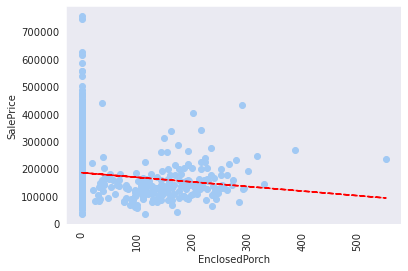

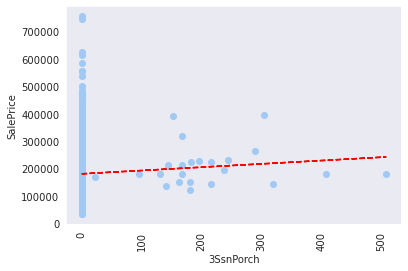

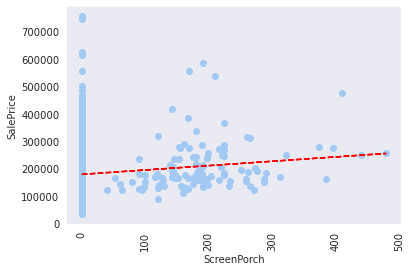

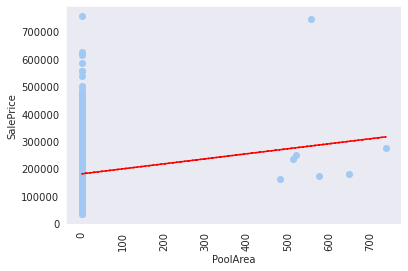

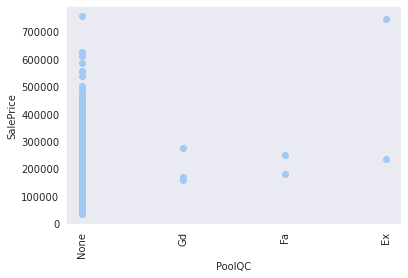

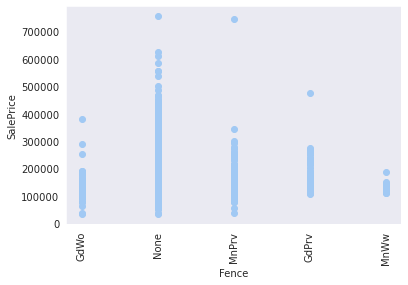

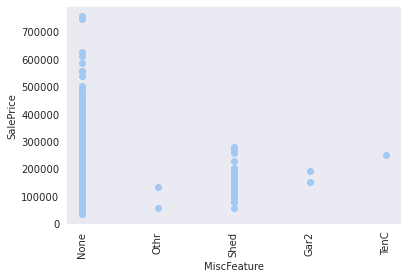

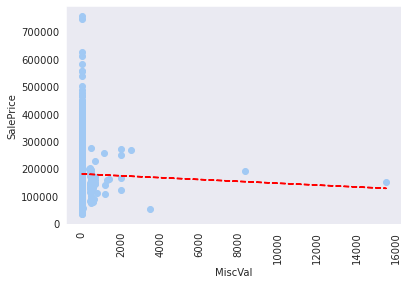

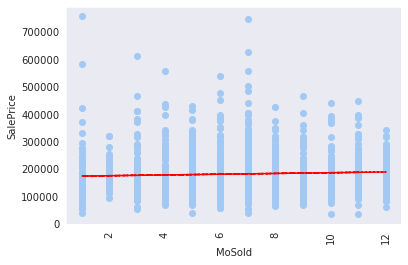

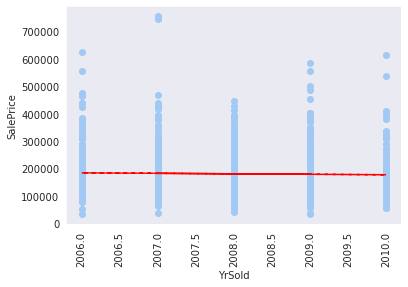

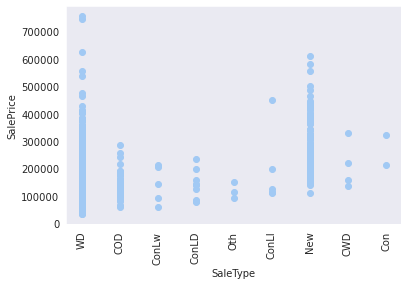

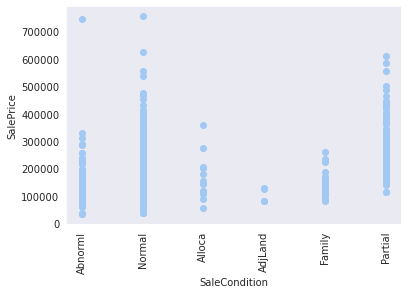

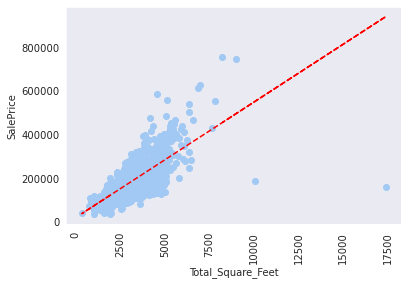

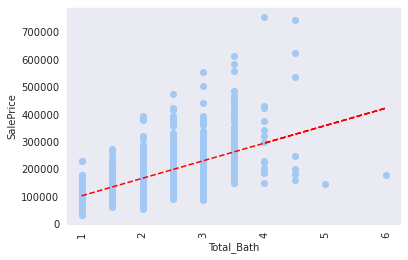

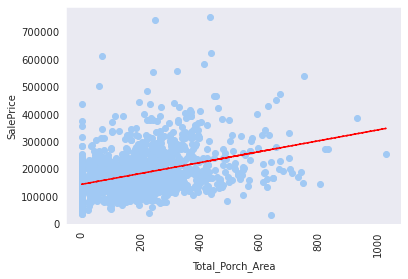

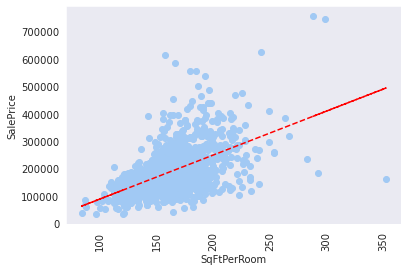

In [63]:
cols = list(test.columns)
for col in cols:
    plot_simple(df, col, 'SalePrice', show_fit=True)

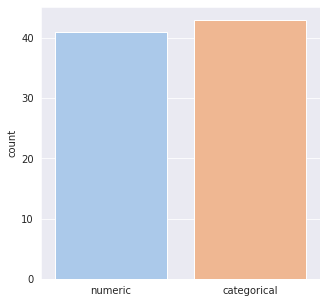

In [64]:
column_data_type = []
for col in df.columns:
    data_type = df[col].dtype
    if df[col].dtype in ['int64','float64']:
        column_data_type.append('numeric')
    else:
        column_data_type.append('categorical')
        
plt.figure(figsize=(5, 5))
sns.countplot(x=column_data_type)
plt.show()

## Distribution of SalePrice

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 180921.20 and sigma = 79415.29



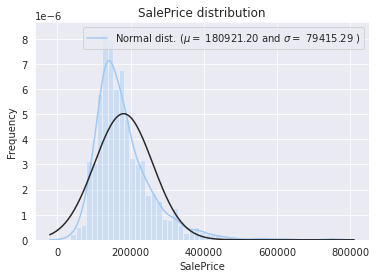

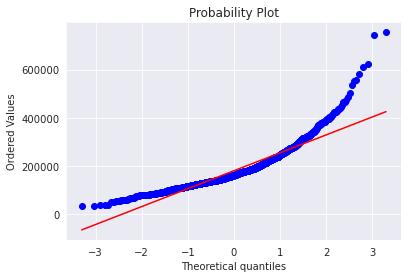

In [65]:
sns.distplot(y , fit=norm);

(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQ-plot
fig = plt.figure()
res = probplot(y, plot=plt)
plt.show()

## Log Transformation

In [66]:
y = np.log(y)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 12.02 and sigma = 0.40



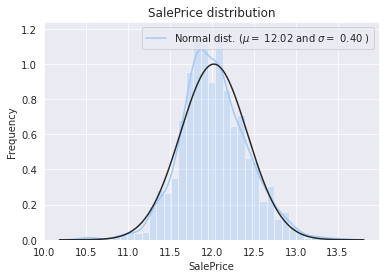

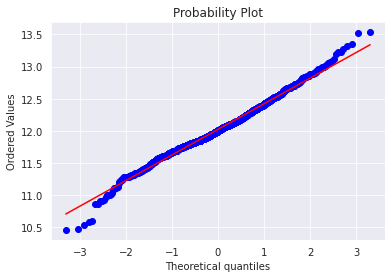

In [67]:
sns.distplot(y , fit=norm);
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = probplot(y, plot=plt)
plt.show()